# CLASSIFICATION OF HUMAN DISEASES FROM X-RAY IMAGES

**Group 6**
- Krishnasurya Gopalakrishnan
- Srinivas Saiteja Tenneti
- Mowzli Sre Mohan Dass

Our final project for the Machine Learning coursework focuses on the Classification of Human Diseases from X-ray Images obtained from Kaggle. This project presents a critical application of machine learning in healthcare, aiming to develop an accurate and reliable system for diagnosing diseases from medical imaging data. 

Our dataset comprises 6326 X-ray images, categorized into classes: **Covid19, Normal, Pneumonia, and Tuberculosis**. Each class represents a distinct medical condition that requires accurate diagnosis and treatment.

**Presentation Recording link:** https://drive.google.com/file/d/1YvmrIvK63LFXkmmMjASHqsgdxyKAf_VB/view?usp=sharing

In [59]:
# Get the absolute path of the current folder
dataset = './data'

## Warning

In [60]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [62]:
import tensorflow as tf
from tensorflow import keras

## Random seed

In [63]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

## Importing Modules

In [64]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


## Data Preprocessing

In [65]:
def load_images_with_labels(base_dir, type_, target_size=(224, 224), batch_size=32):
    """
    Loads images with their corresponding labels from a directory.

    Args:
    - base_dir (str): The base directory containing the image data. It should have subdirectories
                      named after each class, with images for each class stored within.
    - type_ (str): Specifies whether to load training, validation, or testing data. This should
                   correspond to the name of the subdirectory within `base_dir`.
    - target_size (tuple): A tuple specifying the target height and width to which all images will
                           be resized. Default is (224, 224) which is common for many convolutional
                           neural network architectures.
    - batch_size (int): The number of samples per batch to load. Default is 32.

    Returns:
    - train_generator (DirectoryIterator): A DirectoryIterator yielding batches of images and their
                                           corresponding labels, augmented according to the specified
                                           parameters.
    - num_classes (int): The number of classes found in the dataset.

    Example:
    train_generator, num_classes = load_images_with_labels(base_dir='data',
                                                           type_='train',
                                                           target_size=(224, 224),
                                                           batch_size=32)
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_dir, type_),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    num_classes = len(train_generator.class_indices)
    
    return train_generator, num_classes


## Model Structure

In [66]:
def create_model(num_classes):
    """
    Creates a deep learning model for image classification based on the ResNet50 architecture.

    Args:
    - num_classes (int): The number of classes in the classification task.

    Returns:
    - model (Model): A Keras Model instance representing the created classification model.

    Example:
    model = create_model(num_classes=10)
    """
    base_model = ResNet50(weights="imagenet", include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # 50% dropout
    model = Model(inputs=base_model.input, outputs=predictions)



    for layer in base_model.layers:
        layer.trainable = False

    return model


## Optimizing and Compiling

In [67]:
def compile_and_train(model, train_generator, epochs):
    """
    Compiles and trains a deep learning model using the specified data generator.

    Args:
    - model (Model): A Keras Model instance representing the neural network model to be trained.
    - train_generator (DirectoryIterator): A DirectoryIterator yielding batches of training data
                                            and their corresponding labels.
    - epochs (int): The number of epochs (iterations over the entire dataset) for training.

    Returns:
    - history (History): A History object containing training metrics such as loss and accuracy
                         recorded during training.

    Example:
    history = compile_and_train(model=model,
                                train_generator=train_generator,
                                epochs=10)
    """
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs)
    return history


## Evaluating the Model

In [68]:
def evaluate_model(model, test_generator):
    """
    Evaluates a trained deep learning model using the specified data generator.

    Args:
    - model (Model): A Keras Model instance representing the trained neural network model.
    - test_generator (DirectoryIterator): A DirectoryIterator yielding batches of testing data
                                           and their corresponding labels.

    Returns:
    - results (list): A list containing evaluation results, typically including test loss and
                      test accuracy.

    Example:
    evaluation_results = evaluate_model(model=model,
                                        test_generator=test_generator)
    print(f"Test Loss: {evaluation_results[0]}\nTest Accuracy: {evaluation_results[1]}")
    """
    results = model.evaluate(test_generator)
    print(f"Test Loss: {results[0]}\nTest Accuracy: {results[1]}")
    return results


## Plotting Graphs

In [69]:
def plot_training_history(history):
    # Plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.title('Model Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    # Plot training loss
    plt.plot(history.history['loss'])
    plt.title('Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train'], loc='upper left')
    plt.show()

In [70]:
def plot_evaluation_results(results):
    metrics = ['Loss', 'Accuracy']
    values = [results[0], results[1]]

    plt.bar(metrics, values, color=['blue', 'green'])
    plt.title('Model Evaluation')
    plt.ylabel('Metric Value')
    plt.show()

### Loading the Dataset

In [71]:
target_size = (224, 224)
batch_size = 16
epochs = 50

In [72]:
# Load data
train_generator, num_classes = load_images_with_labels(base_dir=dataset, type_="train", target_size=target_size, batch_size=batch_size)

Found 6326 images belonging to 4 classes.


### Identifying Classes

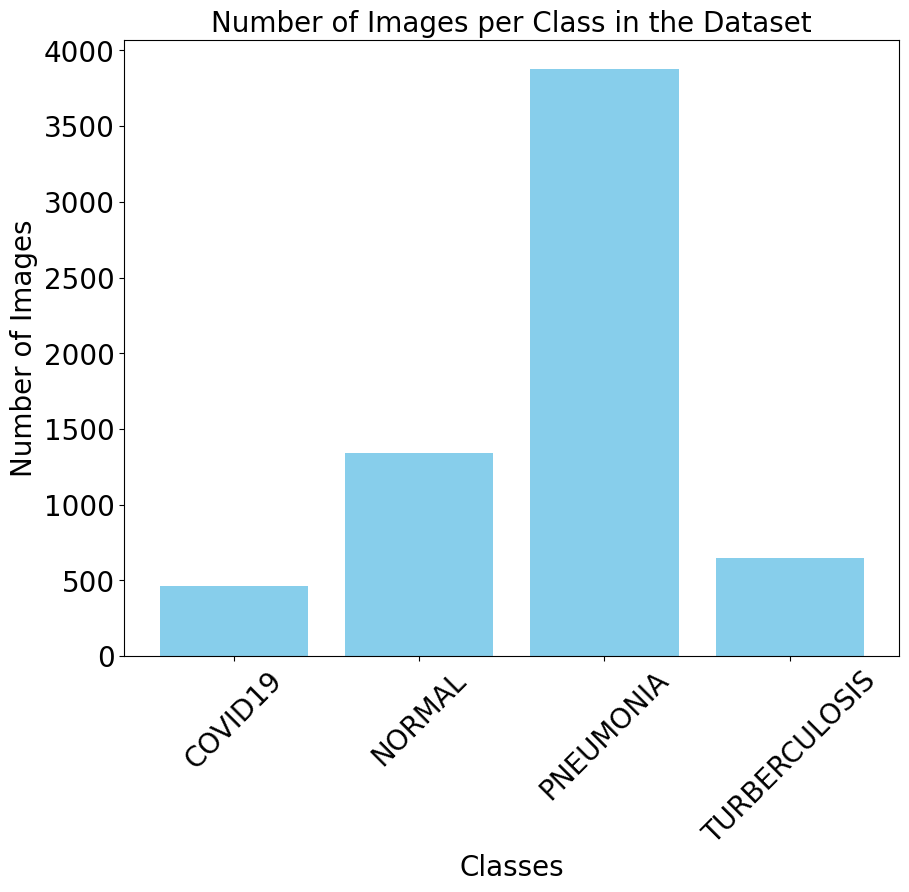

In [80]:
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Iterate through batches to count classes
for batch, labels in train_generator:
    for label in labels:
        class_name = list(class_indices.keys())[list(class_indices.values()).index(np.argmax(label))]
        class_counts[class_name] += 1

    # Since the generator loops indefinitely, break after one pass through the dataset
    if sum(class_counts.values()) >= train_generator.samples:
        break

# Creating the plot
plt.figure(figsize=(10, 8))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Dataset')
plt.xticks(rotation=45)
plt.show()

In [81]:
class_counts

{'COVID19': 460, 'NORMAL': 1341, 'PNEUMONIA': 3875, 'TURBERCULOSIS': 650}

**The dataset consists of 4 different classes: COVID19, NORMAL, PNEUMONIA, TUBERCULOSIS**

Among the classes, Pneumonia has the highest amount of data

### Compiling and Fitting the Model

In [73]:
# Create and compile model
model = create_model(num_classes)


In [74]:
# Train the model
history = compile_and_train(model, train_generator, epochs)

Epoch 1/50
396/396 [==============================] - 88s 216ms/step - loss: 1.0348 - accuracy: 0.6113
Epoch 2/50
396/396 [==============================] - 85s 215ms/step - loss: 0.9752 - accuracy: 0.6197
Epoch 3/50
396/396 [==============================] - 85s 215ms/step - loss: 0.9358 - accuracy: 0.6394
Epoch 4/50
396/396 [==============================] - 85s 215ms/step - loss: 0.9141 - accuracy: 0.6465
Epoch 5/50
396/396 [==============================] - 86s 216ms/step - loss: 0.8897 - accuracy: 0.6502
Epoch 6/50
396/396 [==============================] - 85s 215ms/step - loss: 0.8775 - accuracy: 0.6549
Epoch 7/50
396/396 [==============================] - 85s 215ms/step - loss: 0.8529 - accuracy: 0.6674
Epoch 8/50
396/396 [==============================] - 85s 215ms/step - loss: 0.8425 - accuracy: 0.6682
Epoch 9/50
396/396 [==============================] - 86s 218ms/step - loss: 0.8223 - accuracy: 0.6693
Epoch 10/50
396/396 [==============================] - 86s 217ms/step - l

After 50 Epoch, the accuracy slowly raised upto 0.7815 with a loss function of 0.5529

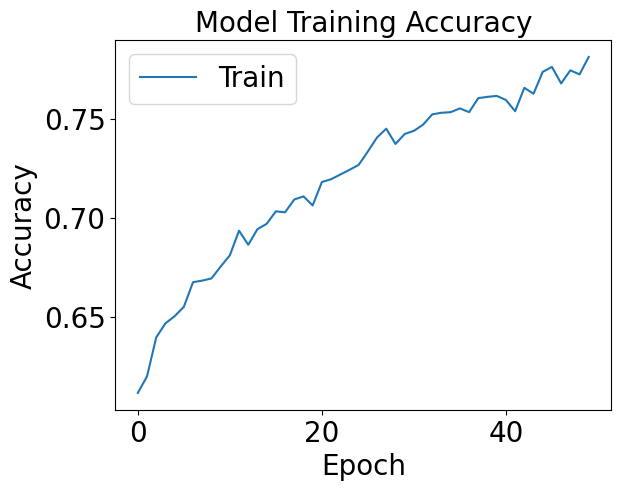

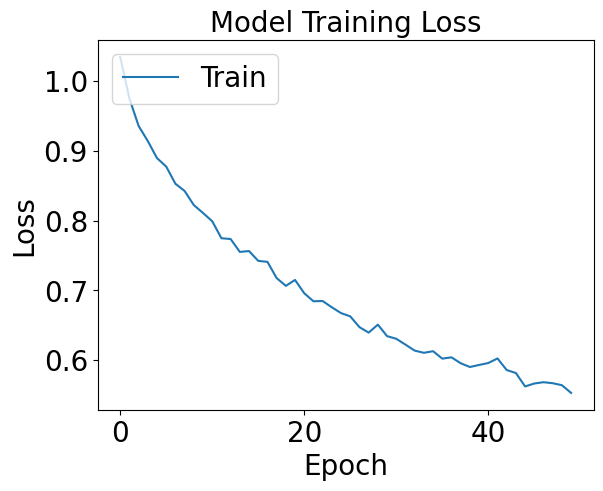

In [75]:

plot_training_history(history)

Upon plotting the learning curve, it is evident that the model is underfit since the learning rate is smoother

In [76]:

test_generator, num_classes = load_images_with_labels(base_dir=dataset, type_="test", target_size=target_size, batch_size=batch_size)

Found 771 images belonging to 4 classes.


In [77]:
results = evaluate_model(model, test_generator)


49/49 [==============================] - 12s 238ms/step - loss: 0.6596 - accuracy: 0.7445
Test Loss: 0.659580647945404
Test Accuracy: 0.7444877028465271


In [78]:
results

[0.659580647945404, 0.7444877028465271]

## Data Balancing

### Balancing the Data

To implement this, the compute_class_weight function is used to balance the dataset by upscaling. Again the model is trained with 30 epochs

In [86]:
from sklearn.utils.class_weight import compute_class_weight

# Example class weights calculation
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(weights))
history = model.fit(train_generator, epochs=30)

Epoch 1/30
396/396 [==============================] - 85s 215ms/step - loss: 0.5434 - accuracy: 0.7823
Epoch 2/30
396/396 [==============================] - 85s 214ms/step - loss: 0.5436 - accuracy: 0.7855
Epoch 3/30
396/396 [==============================] - 85s 215ms/step - loss: 0.5252 - accuracy: 0.7978
Epoch 4/30
396/396 [==============================] - 85s 214ms/step - loss: 0.5348 - accuracy: 0.7923
Epoch 5/30
396/396 [==============================] - 85s 215ms/step - loss: 0.5223 - accuracy: 0.7918
Epoch 6/30
396/396 [==============================] - 85s 214ms/step - loss: 0.5199 - accuracy: 0.7945
Epoch 7/30
396/396 [==============================] - 85s 214ms/step - loss: 0.5115 - accuracy: 0.7985
Epoch 8/30
396/396 [==============================] - 85s 216ms/step - loss: 0.5126 - accuracy: 0.7943
Epoch 9/30
396/396 [==============================] - 85s 215ms/step - loss: 0.5397 - accuracy: 0.7792
Epoch 10/30
396/396 [==============================] - 85s 214ms/step - l

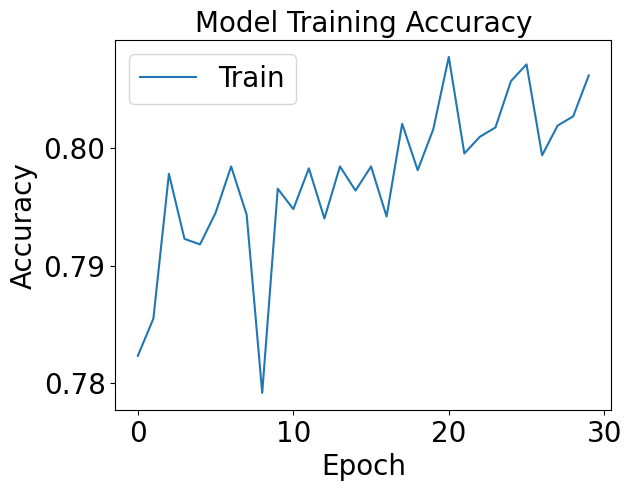

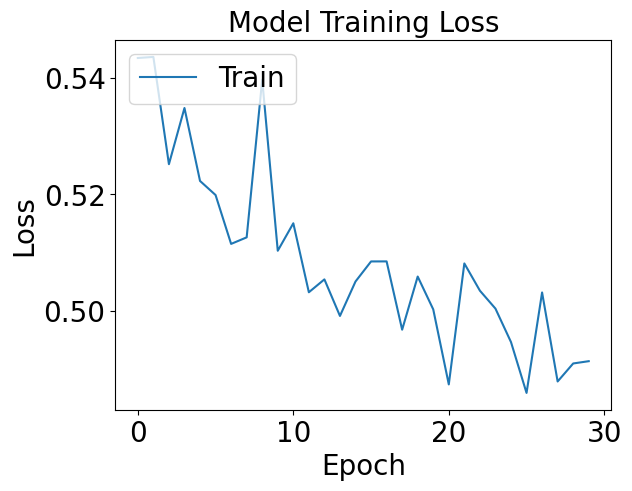

In [87]:
plot_training_history(history)

In [88]:
results = evaluate_model(model, test_generator)


49/49 [==============================] - 12s 238ms/step - loss: 0.4910 - accuracy: 0.8123
Test Loss: 0.491031567802349
Test Accuracy: 0.8123456789012345


After updating the model, the model showed a stable trend with an overall score of 0.81 with a loss function of 0.4910